# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [105]:
DATASET = 'FashionMNIST'
POSTFIX = 'Adam-32-30'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'
SEED = 42
CUDA = 0
LHL = int(POSTFIX.split('-')[-1])
GPU_NAME = f'cuda:{CUDA}'

In [2]:
TEST_DATASET = 'MNIST'
TEST_POSTFIX = 'Adam-32-30'
TEST_FILENAME_POSTFIX = f'{TEST_DATASET}_{TEST_POSTFIX}'

In [3]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

from fastprogress import progress_bar

from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [23]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']


# load config file
configs = load_json(paths['configuration'])
config = configs['configuration']

# model config
model_setup = configs['model_setup']
model_config = configs['model_config']

# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model

PosixPath('/home/ah19/runtime-monitoring/experiments/FashionMNIST/saved-models/FashionMNIST_Adam-32-30/FashionMNIST_Adam-32-30-acc-0.926-loss-0.209.pth.tar')

In [9]:
test_paths = fetchPaths(base, TEST_DATASET, TEST_POSTFIX, False)

test_path_data = test_paths['data']
test_path_lhl = test_paths['lhl']
test_path_lhl_raw = test_paths['lhl_raw']
test_path_lhl_pca = test_paths['lhl_pca']

# Get LHL Data for the Test Dataset

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn

In [11]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
    'cifar10': Cifar10_DLA    
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [12]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [13]:
feature_names = get_labels(TEST_DATASET)

train_data = get_dataset(TEST_DATASET, test_path_data, train=True, transform=transformer['train'])
test_data = get_dataset(TEST_DATASET, test_path_data, train=False, transform=transformer['test'])
len(train_data), len(test_data)

(60000, 10000)

In [14]:
feature_names

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [15]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

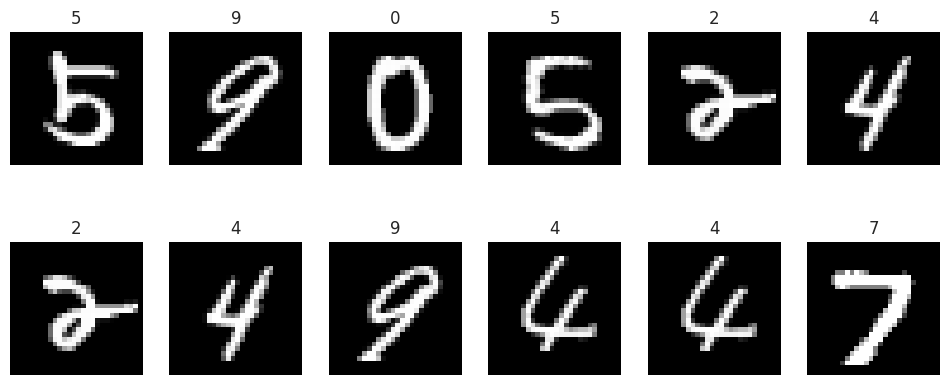

In [16]:
show_images_loader(trainloader, feature_names=feature_names)

In [42]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = LHL
model = model_(**model_setup).to(device)
model = torch.compile(model)

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

''

''

In [68]:
assert (len(trainloader) * model_config['batch_size']) == len(train_data)

In [58]:
res = torch.zeros((len(trainloader), model_config['batch_size'], LHL))

torch.Size([32, 30])

In [67]:
for i, (x, _) in enumerate(trainloader):
    x = x.to(device)
    logits, _ = model.output_last_layer(x)
    res[i] = logits

In [108]:
(res.reshape([len(train_data), LHL])[:model_config['batch_size']] == res[0]).all()

tensor(True)

In [109]:
inference_df = pd.DataFrame(res.reshape([len(train_data), LHL]), columns=[f'x_{i}' for i in range(LHL)])

In [149]:
num_samples = 20

viz_sample = inference_df.sample(num_samples)
x = np.repeat(np.arange(LHL, dtype=np.int8), num_samples) + 1

<Axes: >

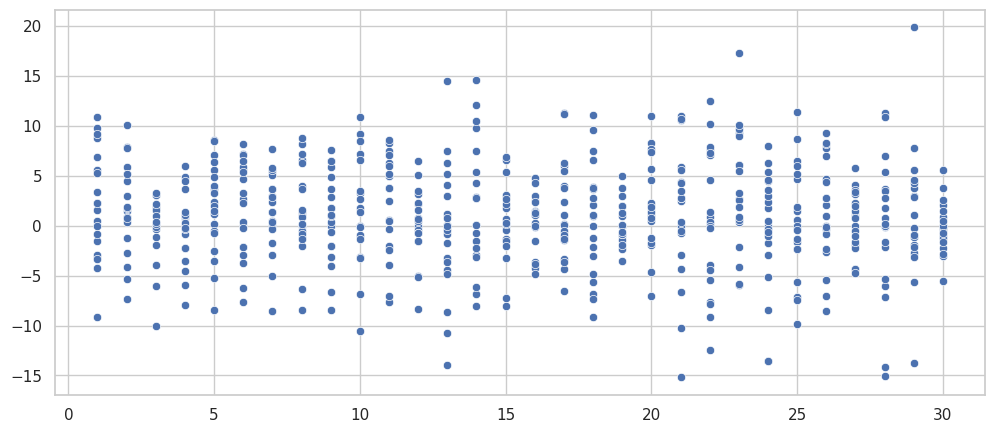

In [150]:
sns.scatterplot(x=x, y=np.reshape(viz_sample.to_numpy(), -1))

# Seed

In [151]:
np.random.seed(SEED)

# Import Data

In [152]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")

# select only true classified
df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

# Build BDD

In [173]:
# each set of data has its own threshold
thld_p = 0.3
eta = 0
neurons = []

# calculate threshold
thld = np.quantile( df_true.loc[ix].drop('y', axis=1), thld_p)
    
# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy()] )

    
# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)

    
# add metadata
patterns.stats['thld'] = f'qth_{thld_p}'

In [174]:
patterns.stats

,thld,eta,build_time,size_mb,reorder_time,num_reorder,num_neurons,start_time,end_time
1,qth_0.3,0.0,0.04,4306.231,0.0,0.0,30.0,2023-07-05 20:12:41,2023-07-05 20:12:43


In [175]:
df_train_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,6000.0,219.0,219.0,0.0,0.036500,1.000000,0.0,0
1,1,6000.0,21.0,21.0,0.0,0.003500,1.000000,0.0,0
2,2,6000.0,173.0,173.0,0.0,0.028833,1.000000,0.0,0
3,3,6000.0,81.0,81.0,0.0,0.013500,1.000000,0.0,0
4,4,6000.0,118.0,118.0,0.0,0.019667,1.000000,0.0,0
5,5,6000.0,6.0,6.0,0.0,0.001000,1.000000,0.0,0
6,6,6000.0,219.0,219.0,0.0,0.036500,1.000000,0.0,0
7,7,6000.0,14.0,14.0,0.0,0.002333,1.000000,0.0,0
8,8,6000.0,27.0,27.0,0.0,0.004500,1.000000,0.0,0
9,9,6000.0,20.0,20.0,0.0,0.003333,1.000000,0.0,0


In [176]:
df_test_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,1000.0,163.0,50.0,113.000000,0.1630,0.306748,0.693252,0
1,1,1000.0,23.0,7.0,16.000000,0.0230,0.304348,0.695652,0
2,2,1000.0,142.0,32.0,110.000000,0.1420,0.225352,0.774648,0
3,3,1000.0,161.0,22.0,139.000000,0.1610,0.136646,0.863354,0
4,4,1000.0,83.0,23.0,60.000000,0.0830,0.277108,0.722892,0
5,5,1000.0,96.0,2.0,94.000000,0.0960,0.020833,0.979167,0
6,6,1000.0,258.0,58.0,200.000000,0.2580,0.224806,0.775194,0
7,7,1000.0,37.0,1.0,36.000000,0.0370,0.027027,0.972973,0
8,8,1000.0,176.0,6.0,170.000000,0.1760,0.034091,0.965909,0
9,9,1000.0,80.0,9.0,71.000000,0.0800,0.112500,0.887500,0


In [177]:
inference_df['y'] = 1
inference_df['true'] = 1

patterns.evaluate_dataframe(inference_df)

,y,count,bdd_false,bdd_false_misclassified,bdd_false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified
0,1,60000.0,31819.0,0.0,31819.0,0.530317,1.000000,0.0
1,all,60000.0,31819.0,0.0,31819.0,0.530317,1.000000,0.0
2,all_mean,60000.0,31819.0,0.0,0.0,0.000000,0.530317,0.0
